In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from alabamaEncode.ai_vmaf.train.train import get_chunks_for_analysis, process_chunks
from alabamaEncode.core.bin_utils import register_bin

register_bin("SvtAv1EncApp", "/home/kokoniara/.local/opt/SvtAv1EncApp")
register_bin("vmaf", "/home/kokoniara/.local/opt/vmaf")
env = os.path.abspath("./ai_feature_extract_test_aom_svt_big_dataset")
if not os.path.exists(env):
    os.mkdir(env)

# getting data
chunks = get_chunks_for_analysis(env)
print(f"Starting processing of {len(chunks)} chunks")
stats = process_chunks(env, chunks)
print(f"Finished processing of {len(chunks)} chunks")

Found scene cache... loading
Computed 25 scenes
Found scene cache... loading
Computed 616 scenes
Found scene cache... loading
Computed 20 scenes
Found scene cache... loading
Computed 4 scenes
Found scene cache... loading
Computed 19 scenes
Found scene cache... loading
Computed 6 scenes
Found scene cache... loading
Computed 12 scenes
Found scene cache... loading
Computed 15 scenes
Starting processing of 702 chunks
Finished processing of 702 chunks


In [2]:
def scale_crf(crf):
    return (((crf - 12) / 46) * 2) - 1


def unscale_crf(crf):
    return 12 + (46 * ((crf + 1) / 2))


features_list = []
labels_list = []

for chunk in stats:
    crf_values = list(
        chunk["chunk_stats"].keys()
    )  # Get the list of CRF values in the chunk

    features_chunk = []

    # print(chunk['aom_features'][0])
    # print("\n")

    for frame in chunk["features"]:
        # Get the list of features for each frame
        # to later copy for each crf value
        # later well add the desired vmaf to each frame per crf value
        feature_values = [float(value) for value in chunk["features"][frame].values()]

        # alt version where we only take the last two keys of the dict
        # feature_values = [float(value) for value in list(chunk["features"][frame].values())[-2:]]

        # feature_values = []

        # we use aom features
        # feature_values = list(chunk['aom_features'][frame].values())

        # we add aom features to the features
        feature_values.extend(list(chunk['aom_features'][frame].values()))

        features_chunk.append(feature_values)

    # thangs = []
    # for crf in crf_values:
    #     thangs.append((crf, chunk["chunk_stats"][crf]["vmaf"]))
    # 
    # # find crf closest to vmaf 94
    # thangs.sort(key=lambda x: abs(x[1] - 94))
    # 
    # crf_closest = thangs[0][0]
    # 
    # print(f"Closest crf to 94: {crf_closest}")
    # 
    # features_list.append(features_chunk)
    # labels_list.append([scale_crf(float(crf_closest))])
    # 
    # continue

    # for each crf sample
    for crf in crf_values:
        vmaf_at_crf = chunk["chunk_stats"][crf]["vmaf"]

        # copy features since they are the same for each crf value
        import copy

        features_with_vmaf = copy.deepcopy(features_chunk)

        # add vmaf to each frame
        for frame in features_with_vmaf:
            frame.append(float(vmaf_at_crf))
        features_list.append(features_with_vmaf)

        # labels = [0] * len(crf_values)
        # the label is a one hot encoded
        # array of size len(crf_values) with zeros except for used crf value
        # 1 at the index of the crf value
        # labels[crf_values.index(crf)] = 1
        # labels_list.append(labels)

        # tensorflow wants a single value instead of a one hot encoded array
        labels_list.append([crf_values.index(crf)])

        # 12 = min; 58 = max; rescale to -1:1 range
        # labels_list.append([float(scale_crf(float(crf)))])

        # print(features_with_vmaf)
        # print(labels)

# print summary of data
print(f"Number of features: {len(features_list[0])}")
print(f"Number of one hot encoded labels: {len(labels_list[0])}")
print(f"Number of samples: {len(features_list)}")


Number of features: 32
Number of one hot encoded labels: 1
Number of samples: 5206


In [3]:
import numpy as np

import tensorflow as tf

tf.random.set_seed(42)

Padding and scaling

In [4]:
# pad the data and turn into numpy arrays 
from keras.preprocessing.sequence import pad_sequences

features_padded = pad_sequences(features_list, dtype="float32", padding="post")

features = np.array(features_padded)
labels = np.array(labels_list)

# min max scale the features
from sklearn.preprocessing import MinMaxScaler
import joblib

original_shape = features.shape
features_reshaped = features.reshape(-1, original_shape[-1])

# Create a MinMaxScaler and fit it to your reshaped data
scaler = MinMaxScaler(feature_range=(-1, 1))
features_scaled = scaler.fit_transform(features_reshaped)

# Reshape the scaled data back to the original shape
features = features_scaled.reshape(original_shape)

joblib.dump(scaler, f"{env}/scaler.pkl")

print(f" Number of samples: {features.shape[0]}")
print(f" Number of padded frames: {features.shape[1]}")
print(f" Number of features per frame: {features.shape[2]}")
print(f" Number of labels: {labels.shape[0]}")
print(f" Number of one hot encoded labels: {labels.shape[1]}")
print(features.shape)
print(labels.shape)


 Number of samples: 5206
 Number of padded frames: 232
 Number of features per frame: 55
 Number of labels: 5206
 Number of one hot encoded labels: 1
(5206, 232, 55)
(5206, 1)


In [29]:

from keras.src.layers import Conv1D
import keras
from keras import Sequential, Input
# create model
from keras.layers import LSTM, BatchNormalization, Masking, Dense

# feature_dim = 1
feature_dim = features.shape[2]
classes_dim = labels.shape[1]
max_frames = features.shape[1]

print(f"feature_dim: {feature_dim}")
print(f"classes_dim: {classes_dim}")

# Define the LS-based model
# model = Sequential([
#     Masking(input_shape=(max_frames, feature_dim)),
#     BatchNormalization(),
#     LSTM(256, return_sequences=True, activation="relu", recurrent_regularizer=keras.regularizers.l1()),
#     LSTM(256, return_sequences=True, activation="relu", recurrent_regularizer=keras.regularizers.l1()),
#     AveragePooling1D(),
#     Conv1D(256, 3, activation="relu"),
#     Conv1D(256, 3, activation="relu"),
#     Flatten(),
#     Dense(128, activation="relu"),
#     Dropout(0.5),
#     Dense(64, activation="relu"),
#     Dense(1, activation="tanh")
# ])
# 
# # Compile the model
# model.compile(optimizer=AdamW(), loss='mape', metrics=['mse', 'mae', 'mape', 'accuracy'])

# Fully Convolutional Neural Network model

print(features[0])
print(labels[0])
print(features.shape)
print(labels.shape)

model = Sequential([
    Input(shape=(max_frames, feature_dim)),
    Conv1D(1024, 5, activation="relu", recurrent_regularizer=keras.regularizers.l1()),
    BatchNormalization(),
    Conv1D(256, 5, activation="relu", recurrent_regularizer=keras.regularizers.l1()),
    BatchNormalization(),
    Conv1D(256, 3, activation="relu", recurrent_regularizer=keras.regularizers.l1()),
    BatchNormalization(),
    Conv1D(256, 3, activation="relu", recurrent_regularizer=keras.regularizers.l1()),
    BatchNormalization(),
    Dense(19, activation="softmax")
])

model.compile(
    loss="sparse_categorical_crossentropy",
    # optimizer=AdamW(),
    optimizer="adam",
    metrics=["sparse_categorical_accuracy"]
)

print(model.summary())

# Train the model with your data
history = model.fit(
    features,
    labels,
    epochs=500,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint(
            "/tmp/video_classifier", save_weights_only=True, save_best_only=True, verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=20, min_lr=0.0001),
    ]
)

feature_dim: 55
classes_dim: 1
[[ 0.5314454   0.5314454   0.600315   ... -0.99999493 -0.99999464
   0.91716063]
 [ 0.53072405  0.53072345  0.5993985  ... -0.47360402 -0.99999326
   0.91716063]
 [ 0.5321225   0.53212345  0.6023357  ... -0.99999493 -0.9999944
   0.91716063]
 ...
 [-1.         -1.         -1.         ... -0.99999493 -0.99999464
  -1.        ]
 [-1.         -1.         -1.         ... -0.99999493 -0.99999464
  -1.        ]
 [-1.         -1.         -1.         ... -0.99999493 -0.99999464
  -1.        ]]
[0]
(5206, 232, 55)
(5206, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 232, 2048)         114688    
                                                                 
 batch_normalization_8 (Bat  (None, 232, 2048)         8192      
 chNormalization)                                                
                              

InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1077, in launch_instance

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 529, in dispatch_queue

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 518, in process_one

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 424, in dispatch_shell

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 766, in execute_request

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_10820/2544362320.py", line 75, in <module>

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/home/kokoniara/dev/VideoSplit/venv/lib/python3.11/site-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

assertion failed: [Condition x == y did not hold element-wise:] [x (sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/Shape_1:0) = ] [32 1] [y (sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/strided_slice:0) = ] [32 232]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert}}]] [Op:__inference_train_function_205686]

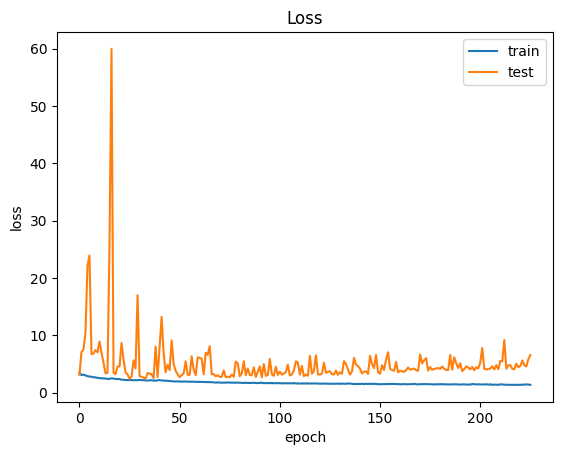

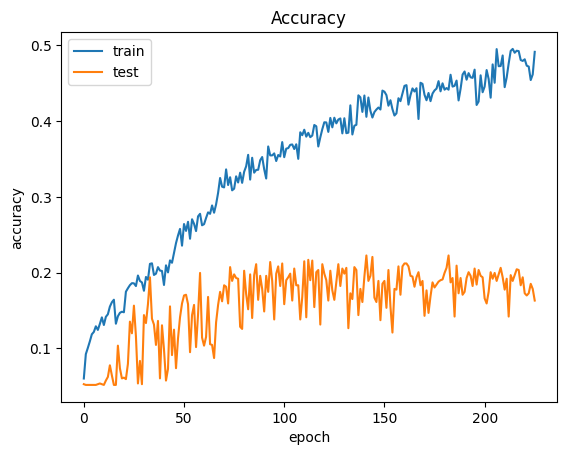

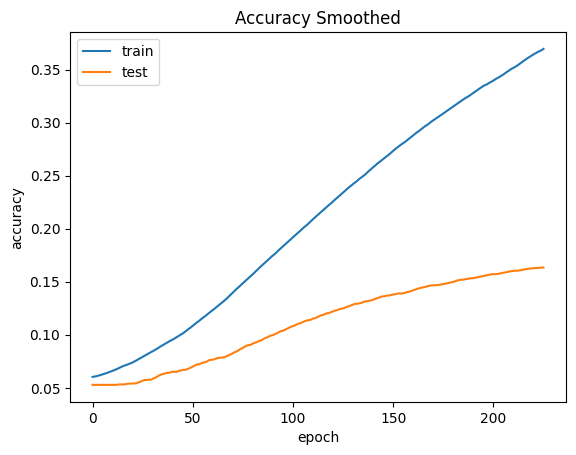

In [14]:
# plot training history
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

# plot accuracy
plt.plot(history.history["sparse_categorical_accuracy"], label="train")
plt.plot(history.history["val_sparse_categorical_accuracy"], label="test")
plt.title("Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()


# plot accuracy with smoothing
def smooth_curve(points, factor=0.99):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


plt.plot(
    smooth_curve(history.history["sparse_categorical_accuracy"]), label="train"
)
plt.plot(
    smooth_curve(history.history["val_sparse_categorical_accuracy"]), label="test"
)
plt.title("Accuracy Smoothed")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [ ]:
from keras_tuner import RandomSearch


def build_model(hp):
    model = Sequential()
    model.add(Masking(input_shape=(max_frames, feature_dim)))
    model.add(BatchNormalization())

    # Tune the number of LSTM layers
    lstm_layer_count = hp.Int('num_lstm_layers', min_value=1, max_value=3, step=1)
    for i in range(lstm_layer_count):
        # Tune the number of units in each LSTM layer
        model.add(LSTM(units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=256, step=32),
                       activation='relu',
                       return_sequences=(i < lstm_layer_count - 1)))

    model.add(Dense(units=classes_dim, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


tuner = RandomSearch(build_model, objective='val_accuracy', directory='keras_tuner_dir',
                     project_name='lstm_tuning')

tuner.search(
    features,
    labels,
    epochs=15,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="loss", patience=4)
    ]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Number of LSTM Layers:", best_hps.get('num_lstm_layers'))
print("Best LSTM Units per Layer:", [best_hps.get(f'lstm_units_{i}') for i in range(best_hps.get('num_lstm_layers'))])


In [15]:
model = keras.models.load_model(f"{env}/model.keras")

In [17]:
# do some predictions on test data
perdictions = model.predict(features)

163/163 [==============================] - 18s 109ms/step


In [15]:
crfs = [
    12,
    15,
    17,
    19,
    21,
    23,
    25,
    27,
    29,
    31,
    34,
    37,
    40,
    43,
    46,
    49,
    52,
    55,
    58,
]

Predicted crf : 25, Ground truth: 12
Predicted crf : 25, Ground truth: 15
Predicted crf : 25, Ground truth: 17
Predicted crf : 25, Ground truth: 19
Predicted crf : 31, Ground truth: 21
Predicted crf : 31, Ground truth: 23
Predicted crf : 37, Ground truth: 25
Predicted crf : 37, Ground truth: 27
Predicted crf : 37, Ground truth: 29
Predicted crf : 37, Ground truth: 31
Predicted crf : 43, Ground truth: 34
Predicted crf : 43, Ground truth: 37
Predicted crf : 43, Ground truth: 40
Predicted crf : 43, Ground truth: 43
Predicted crf : 55, Ground truth: 46
Predicted crf : 55, Ground truth: 49
Predicted crf : 55, Ground truth: 52
Predicted crf : 55, Ground truth: 55
Predicted crf : 55, Ground truth: 58
Predicted crf : 19, Ground truth: 12
Predicted crf : 19, Ground truth: 15
Predicted crf : 19, Ground truth: 17
Predicted crf : 19, Ground truth: 19
Predicted crf : 19, Ground truth: 21
Predicted crf : 19, Ground truth: 23
Predicted crf : 25, Ground truth: 25
Predicted crf : 25, Ground truth: 27
P

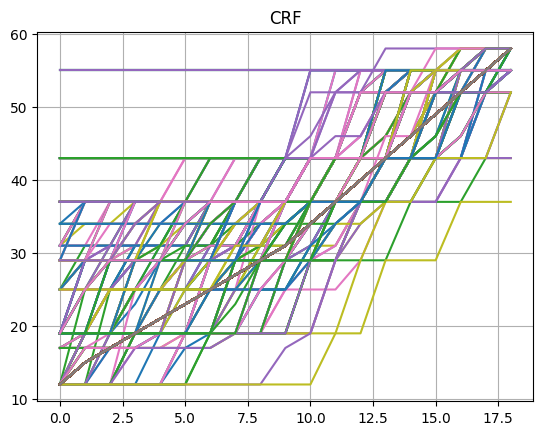

In [26]:
arr = []
arr_c = []
for i in range(features.shape[0]):

    perdiction = perdictions[i]
    # pick the highest value
    perdiction = np.argmax(perdiction)
    perdiction = crfs[perdiction]
    truth = int(labels[i:i + 1][0][0])
    truth = crfs[truth]

    arr_c.append((perdiction, truth))
    if truth == 58 and len(arr_c) > 1:
        arr.append(arr_c)
        arr_c = []
    print(f"Predicted crf : {perdiction}, Ground truth: {truth}")

import matplotlib.pyplot as plt

plt.grid()
# set both x and y to equal length
for ar in arr:
    plt.plot([x[0] for x in ar], label="predicted")
    plt.plot([x[1] for x in ar], label="ground truth")
    plt.title("CRF")



In [51]:
# save the model
model.save(f"{env}/model.keras")

In [3]:

import keras

model = keras.models.load_model(f"{env}/model.keras")


In [25]:
# load model, get a random example from `stats` and do a prediction on it 

import numpy as np
import random
from keras.preprocessing.sequence import pad_sequences
import joblib

# model = keras.models.load_model(f"{env}/model.keras")

correct = 0
num_tests = stats.__len__()

for i in range(num_tests):
    chunk = random.choice(stats)
    crf_values = list(chunk["chunk_stats"].keys())
    features_chunk = []

    for frame in chunk["features"]:
        # feature_values = [float(value) for value in list(chunk["features"][frame].values())[-2:]]
        feature_values = [float(value) for value in list(chunk["features"][frame].values())]
        feature_values.extend(list(chunk['aom_features'][frame].values()))
        features_chunk.append(feature_values)

    features_chunk = np.array(features_chunk)

    # print(features_chunk.shape)

    # add vmaf 94 to each frame
    features_chunk = np.concatenate(
        (features_chunk, np.full((features_chunk.shape[0], 1), 94)), axis=1
    )
    # print(features_chunk.shape)

    # pad to 232 frames
    features_chunk = pad_sequences(
        [features_chunk], dtype="float32", padding="post", maxlen=232
    )[0]

    # print(features_chunk.shape)

    # reshape
    features_chunk = features_chunk.reshape(1, features_chunk.shape[0], features_chunk.shape[1])

    print(features_chunk.shape)

    # scale
    scaler = joblib.load(f"{env}/scaler.pkl")
    original_shape = features_chunk.shape
    features_reshaped = features_chunk.reshape(-1, original_shape[-1])
    features_scaled = scaler.transform(features_reshaped)
    features_scaled = features_scaled.reshape(original_shape)
    features_chunk = features_scaled
    # print(features_chunk)

    perdiction = model.predict(features_chunk, verbose=0)
    # perdiction = int(unscale_crf(perdiction[0][0]))

    # pick the highest value
    perdiction = np.argmax(perdiction)
    perdiction = crf_values[perdiction]

    # find crf thats closes to vmaf 94
    thangs = []
    for crf in crf_values:
        thangs.append((crf, chunk["chunk_stats"][crf]["vmaf"]))

    # find crf closest to vmaf 94
    thangs.sort(key=lambda x: abs(float(x[1]) - 94))

    crf_closest_real = int(thangs[0][0])
    vmaf_closest_real = float(thangs[0][1])

    crf_error_delta = abs(float(crf_closest_real) - float(perdiction))

    # look for a value closest to predicted crf in dataset and print its vmaf compared to the real's crf's vmaf
    thangs.sort(key=lambda x: abs(float(x[0]) - float(perdiction)))

    vmaf_perdiction_error = abs(float(thangs[0][1]) - float(vmaf_closest_real))

    print(
        f"perdiction: crf {perdiction} VMAF{thangs[0][1]}; real: crf {crf_closest_real}, vmaf {vmaf_closest_real}, crf error delta {crf_error_delta} vmaf error delta {vmaf_perdiction_error}")

    if crf_error_delta <= 1:
        correct += 1

print(f"within 1 vmaf accuracy: {(correct / num_tests) * 100}%")

(1, 232, 55)
perdiction: crf 37 VMAF91.829315; real: crf 43, vmaf 89.725731, crf error delta 6.0 vmaf error delta 2.103583999999998
(1, 232, 55)
perdiction: crf 43 VMAF93.805475; real: crf 52, vmaf 89.549978, crf error delta 9.0 vmaf error delta 4.255497000000005
(1, 232, 55)
perdiction: crf 43 VMAF93.805475; real: crf 52, vmaf 89.549978, crf error delta 9.0 vmaf error delta 4.255497000000005
(1, 232, 55)
perdiction: crf 52 VMAF88.117516; real: crf 49, vmaf 90.456856, crf error delta 3.0 vmaf error delta 2.339340000000007
(1, 232, 55)
perdiction: crf 43 VMAF96.370605; real: crf 55, vmaf 89.725048, crf error delta 12.0 vmaf error delta 6.645556999999997
(1, 232, 55)
perdiction: crf 43 VMAF93.36576; real: crf 46, vmaf 91.06268, crf error delta 3.0 vmaf error delta 2.3030799999999942
(1, 232, 55)
perdiction: crf 43 VMAF95.327186; real: crf 49, vmaf 89.78845, crf error delta 6.0 vmaf error delta 5.538736
(1, 232, 55)
perdiction: crf 37 VMAF85.433986; real: crf 25, vmaf 90.308358, crf error